In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from feature_engine.outliers import OutlierTrimmer

---

# Utils

In [2]:
import matplotlib.gridspec as gridspec


def show_data(data):
    data.info()
    print("\n\nThe columns are {}".format(data.columns))
    print("\n\nActual Data\n",data.head(2))

# outliers

def trimmer_skewed_iqr(variables, data_frame):
    return _build_trimmer(variables, 'iqr', 1.5, data_frame)

def trimmer_normal_gaussian(variables, data_frame):
    return _build_trimmer(variables, 'gaussian', 3, data_frame)

def trimmer_normal_quantile(variables, data_frame):
    return _build_trimmer(variables, 'quantiles', 0.01, data_frame)

def _build_trimmer(variables, capping_method, fold, data_frame):
    return OutlierTrimmer(
        variables=variables,
        capping_method=capping_method,
        tail='both',
        fold=fold
    ).fit_transform(data_frame)

def distinguish_variables(data):
    # Identificação dos tipos de variáveis, se são numéricas ou categóricas
    # - Numéricas são as int64 e float64;
    # - Categóricas são as object;
    numerical = [var for var in data.columns if data[var].dtype != "O"]
    categorical = [var for var in data.columns if data[var].dtype == "O"]
    # Identificação das variáveis discretas:
    # - Se tiver MENOS que 20 registros, é considerado uma variável DISCRETA;
    discrete = []
    for var in numerical:
        if len(data[var].unique()) < 20:
            discrete.append(var)
    # Identificação das variáveis contínuas:
    # - Se tiver MAIS que 20 registros, é considerado uma variável CONTÍNUA;
    continuous = [var for var in numerical if var not in discrete]

    return numerical, categorical, discrete, continuous

def visualize_discrete(df, discrete, show_red_line):
    plt.figure(figsize=(10, 5))
    position = 0
    for var in discrete:
        position += 1
        plt.subplot(2, 3, position)
        fig = (df.groupby(var)[var].count() / len(df)).plot.bar()
        # fig.set_title(var)
        fig.set_ylabel('observations per label (%)')
        fig.set_xlabel(var)
        if show_red_line: fig.axhline(y=0.01, color='red')
    
    for var in discrete:
        position += 1
        plt.subplot(2, 3, position)
        fig = df.groupby(var)['rent'].median().plot()
        fig.set_ylabel('Median rent per label')
        fig.set_xlabel(var)
        # fig.set_title(var)
        fig.ticklabel_format(style='plain')

    plt.tight_layout()
    plt.show()
    

def new_visualize_discrete(df, discrete, show_red_line):
    fig = plt.figure(figsize=(7, 10))

    for i, var in enumerate(discrete, start=1):
        # df mean
        median_df = df.groupby(var)['rent'].median().reset_index()
        # df count
        count_df = df[var].value_counts(normalize=True).reset_index()
        count_df.columns = [var, 'count']

        ax1 = fig.add_subplot(3, 1, i)
        ax1.bar(count_df[var], count_df['count'], color='#3274A1', label='observations per label (%)')
        if show_red_line:
            ax1.axhline(y=0.01, color='red', linestyle='--', label='cut-off line for outliers (1%)')

        # Gráfico de linhas
        ax2 = ax1.twinx()
        ax2.plot(median_df[var], median_df['rent'], color='#E1812C', marker='o', label='median rent per label')
        
        # ajustando os limites superiores de y para a legenda não sobrepor o gráfico
        ax1.set_ylim(0, 1.3 * count_df['count'].max())
        ax2.set_ylim(0, 1.3 * median_df['rent'].max())

        ax1.legend(loc='upper left')
        ax1.set_xlabel(str('number of ' + var))
        ax1.tick_params('y', colors='#3274A1')

        ax2.legend(loc='upper right')
        ax2.tick_params('y', colors='#E1812C')

        plt.subplots_adjust(hspace=0.5)  # Ajuste conforme necessário


    # plt.tight_layout()
    # plt.subplots_adjust(bottom=0.2)
    plt.show()


def visualize_continuous(df, continuous):
    plt.figure(figsize=(40, 6))
    position = 0
    for var in continuous:
        position += 1
        plt.subplot(2, 5, position)
        fig = df.boxplot(column=var, vert=False)
        fig.set_title('')
        fig.set_yticklabels([])

    for var in continuous:
        position += 1
        plt.subplot(2, 5, position)
        fig = df[var].hist(bins=20)
        fig.set_ylabel('Number of records', fontsize=16)
        fig.set_xlabel(var, fontsize=16)
    
    plt.tight_layout()
    plt.show()

def visualize_boxplot(df):
    plt.rcParams["figure.figsize"] = [14.00, 14.00]
    plt.rcParams["figure.autolayout"] = True

    plt.rcParams['font.size'] = 10 
    plt.rcParams['axes.titlesize'] = 20

    f, axes = plt.subplots(2, 5)

    linha = 0
    coluna = 0
    for i in numerical:
        sns.boxplot(data = df, y=i, ax=axes[linha][coluna])
        coluna += 1
        if coluna == 5:
            linha += 1
            coluna = 0            

    plt.show() 

---

# Pré-processamento dos dados

- city: Cidade
- area: Área (m²)
- rooms: Quartos
- bathroom: Banheiros
- parking spaces: Vagas de Estacionamento
- floor: Andar
- animal: Animal
- furniture: Mobília
- hoa (R$): Condomínio (R$)
- rent amount (R$): Aluguel (R$)
- property tax (R$): IPTU (R$)
- fire insurance (R$): Seguro de Incêndio (R$)
- total (R$): Total (R$)

### Correções gerais 

In [3]:
data = pd.read_csv("datasets/houses_to_rent_v2.csv")
data.rename({'parking spaces': 'parking_spaces', 
             'hoa (R$)': 'hoa', 
             'rent amount (R$)': 'rent', 
             'property tax (R$)': 'property_tax', 
             'fire insurance (R$)': 'fire_insurance', 
             'total (R$)': 'total'}, axis='columns', inplace=True)

df = data.drop(["total"], axis=1) # soma dos valores, não deve permanecer no conjunto

df.head()

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent,property_tax,fire_insurance
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11


### Tratamento dos valores nulos

In [4]:
df.info()
# Não há valores nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   city            10692 non-null  object
 1   area            10692 non-null  int64 
 2   rooms           10692 non-null  int64 
 3   bathroom        10692 non-null  int64 
 4   parking_spaces  10692 non-null  int64 
 5   floor           10692 non-null  object
 6   animal          10692 non-null  object
 7   furniture       10692 non-null  object
 8   hoa             10692 non-null  int64 
 9   rent            10692 non-null  int64 
 10  property_tax    10692 non-null  int64 
 11  fire_insurance  10692 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1002.5+ KB


### Tratamento de duplicatas

In [5]:
df.duplicated().value_counts()

False    10334
True       358
Name: count, dtype: int64

In [6]:
df.drop_duplicates(inplace=True)
df.duplicated().value_counts()

False    10334
Name: count, dtype: int64

### Distinção das variáveis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10334 entries, 0 to 10691
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   city            10334 non-null  object
 1   area            10334 non-null  int64 
 2   rooms           10334 non-null  int64 
 3   bathroom        10334 non-null  int64 
 4   parking_spaces  10334 non-null  int64 
 5   floor           10334 non-null  object
 6   animal          10334 non-null  object
 7   furniture       10334 non-null  object
 8   hoa             10334 non-null  int64 
 9   rent            10334 non-null  int64 
 10  property_tax    10334 non-null  int64 
 11  fire_insurance  10334 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [8]:
numerical, categorical, discrete, continuous = distinguish_variables(df)

print("Categoricas: " + str(categorical))
print("Numericas: " + str(numerical))

print(" - Discretas: " + str(discrete))
print(" - Contínuas: " + str(continuous))

Categoricas: ['city', 'floor', 'animal', 'furniture']
Numericas: ['area', 'rooms', 'bathroom', 'parking_spaces', 'hoa', 'rent', 'property_tax', 'fire_insurance']
 - Discretas: ['rooms', 'bathroom', 'parking_spaces']
 - Contínuas: ['area', 'hoa', 'rent', 'property_tax', 'fire_insurance']


# Estudo das variáveis 

## Categoricas
- ['city', 'floor', 'animal', 'furniture']

In [9]:
for var in categorical:
    print('Variável:', var)
    print('  - Resultados possíveis: ', df[var].unique())
    print('\r')

Variável: city
  - Resultados possíveis:  ['São Paulo' 'Porto Alegre' 'Rio de Janeiro' 'Campinas' 'Belo Horizonte']

Variável: floor
  - Resultados possíveis:  ['7' '20' '6' '2' '1' '-' '4' '3' '10' '11' '24' '9' '8' '17' '18' '5'
 '13' '15' '16' '14' '26' '12' '21' '19' '22' '27' '23' '35' '25' '46'
 '28' '29' '301' '51' '32']

Variável: animal
  - Resultados possíveis:  ['acept' 'not acept']

Variável: furniture
  - Resultados possíveis:  ['furnished' 'not furnished']



### city

Relação "city" vs "rent"
- Campinas e Porto Alegre são cidades as quais há mais frequência de alugueis de baixo valor;
- Equanto São Paulo e Rio de Janeiro há aluguei com valores mais elevados;
- Belo Horizonte seria um meio termo entre eles;

Conforme abaixo, a feature "city" possui grande relação com o preço do imóvel.
- Feature Eng: aplicar OneHotEncoded

In [10]:
pd.DataFrame(df['city'].unique())

,0
0,São Paulo
1,Porto Alegre
2,Rio de Janeiro
3,Campinas
4,Belo Horizonte


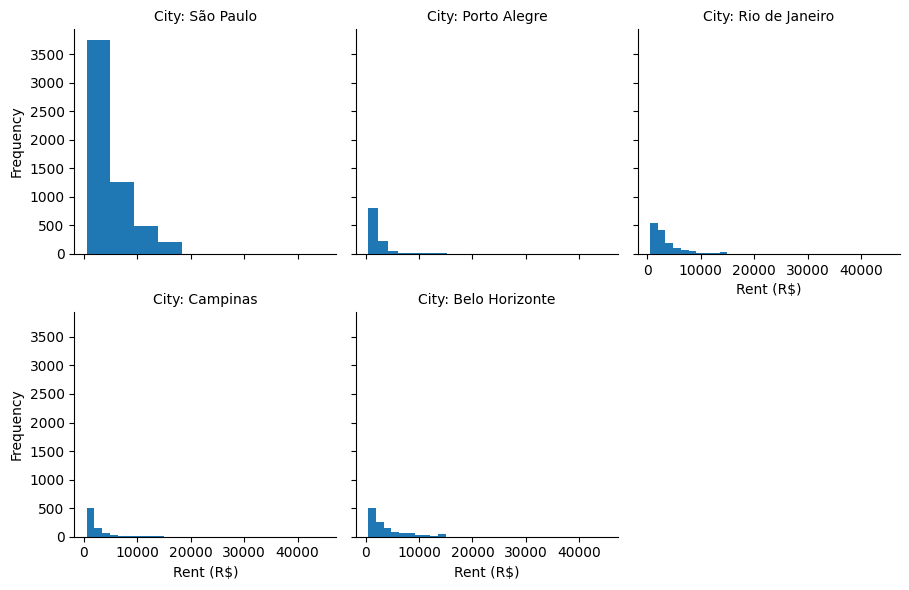

In [11]:
g = sns.FacetGrid(df, col='city', height=3, col_wrap=3)
g = g.map(plt.hist, 'rent')

g.set_axis_labels('Rent (R$)', 'Frequency')
g.set_titles('City: {col_name}')

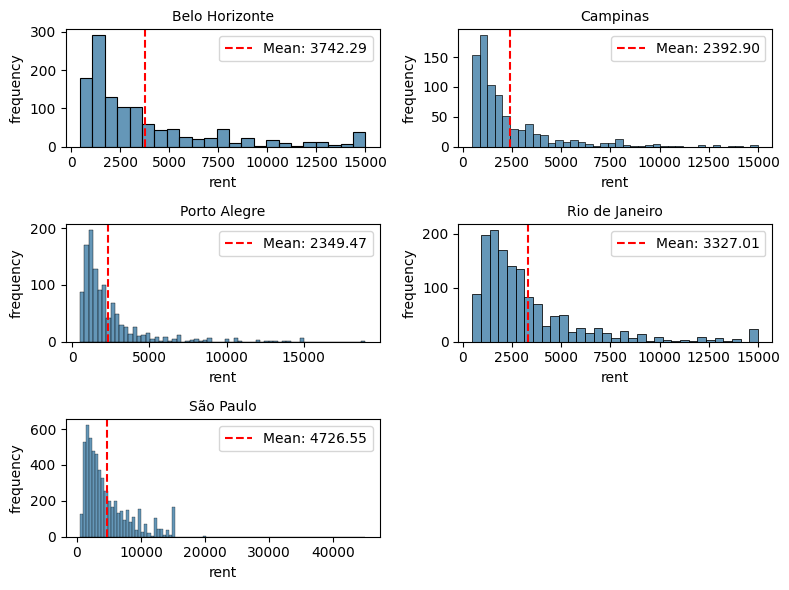

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dividir os dados em grupos com base na coluna 'city'
city_groups = df.groupby('city')

# Configurar o layout dos gráficos
fig = plt.figure(figsize=(8, 6))
grid = plt.GridSpec(3,2)

for i, (city, data) in enumerate(city_groups):
    # Calcule a posição do subplot com base no índice i
    ax = plt.Subplot(fig, grid[i // 2, i % 2])

    fig.add_subplot(ax)

    # Crie o histograma
    sns.histplot(data['rent'], ax=ax, color='#3274A1')
    
    # Calcule a média de 'rent' para a cidade atual
    mean_rent = data['rent'].mean()
    
    # Adicione a linha vermelha tracejada para a média
    ax.axvline(mean_rent, color='red', linestyle='--', label=f'Mean: {mean_rent:.2f}')
    
    ax.set_xlabel('rent')
    ax.set_ylabel('frequency')
    ax.set_title(f'{city}', fontsize=10)
    ax.legend()

plt.tight_layout()
plt.show()


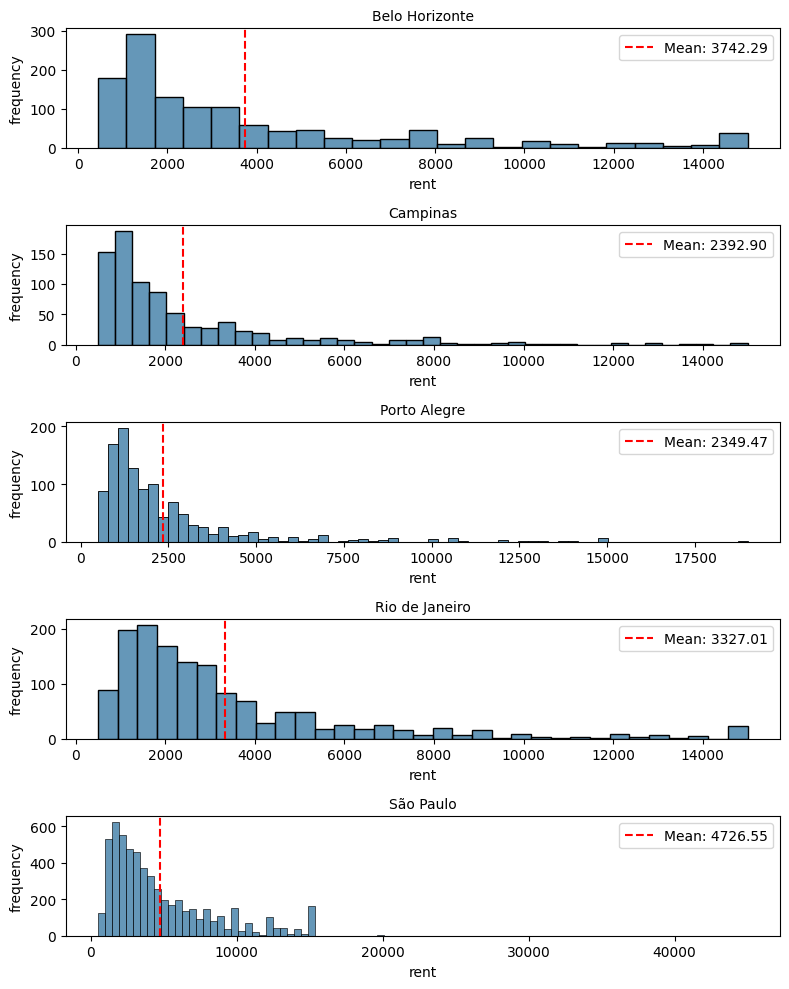

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dividir os dados em grupos com base na coluna 'city'
city_groups = df.groupby('city')

# Configurar o layout dos gráficos
fig = plt.figure(figsize=(8, 10))
grid = plt.GridSpec(5,1)

for i, (city, data) in enumerate(city_groups):
    # Calcule a posição do subplot com base no índice i
    ax = plt.Subplot(fig, grid[i // 1, i % 1])

    fig.add_subplot(ax)

    # Crie o histograma
    sns.histplot(data['rent'], ax=ax, color='#3274A1')
    
    # Calcule a média de 'rent' para a cidade atual
    mean_rent = data['rent'].mean()
    
    # Adicione a linha vermelha tracejada para a média
    ax.axvline(mean_rent, color='red', linestyle='--', label=f'Mean: {mean_rent:.2f}')
    
    ax.set_xlabel('rent')
    ax.set_ylabel('frequency')
    ax.set_title(f'{city}', fontsize=10)
    ax.legend()

plt.tight_layout()
plt.show()


### floor
É difícil relacionar o andar com o preço do imóvel, levando em conta que a maioria dos dados não possui um andar registrado.
- Portanto, floor será ignorado;


Text(0, 0.5, 'Frequency')

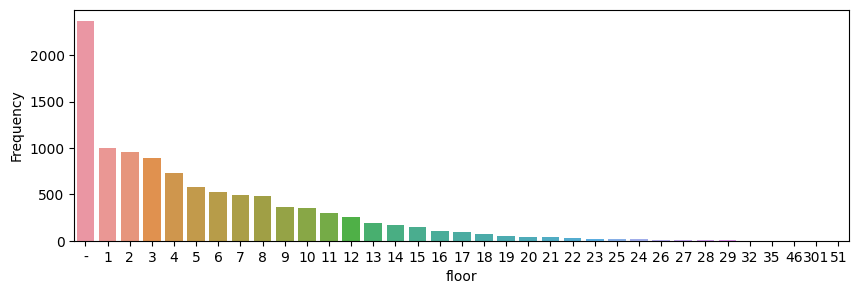

In [13]:
floor_counts = df["floor"].value_counts()

plt.figure(figsize=(10, 3))
sns.barplot(x=floor_counts.index, y=floor_counts.values)
plt.ylabel("Frequency")

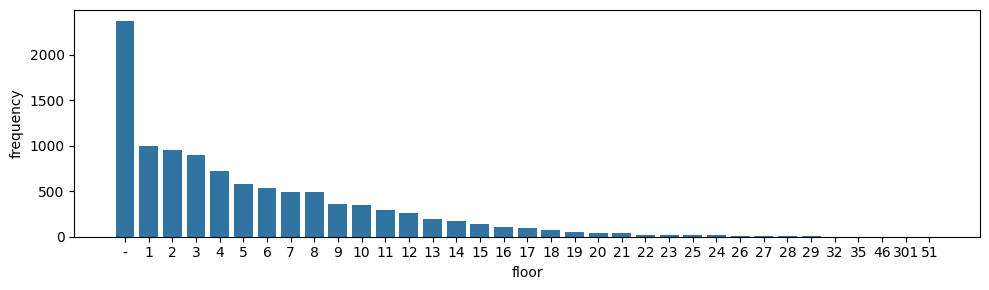

In [69]:
import matplotlib.pyplot as plt

floor_counts = df["floor"].value_counts()
plt.figure(figsize=(10, 3))
plt.bar(floor_counts.index, floor_counts.values, color='#3274A1')
plt.xlabel("floor")
plt.ylabel("frequency")
plt.show()


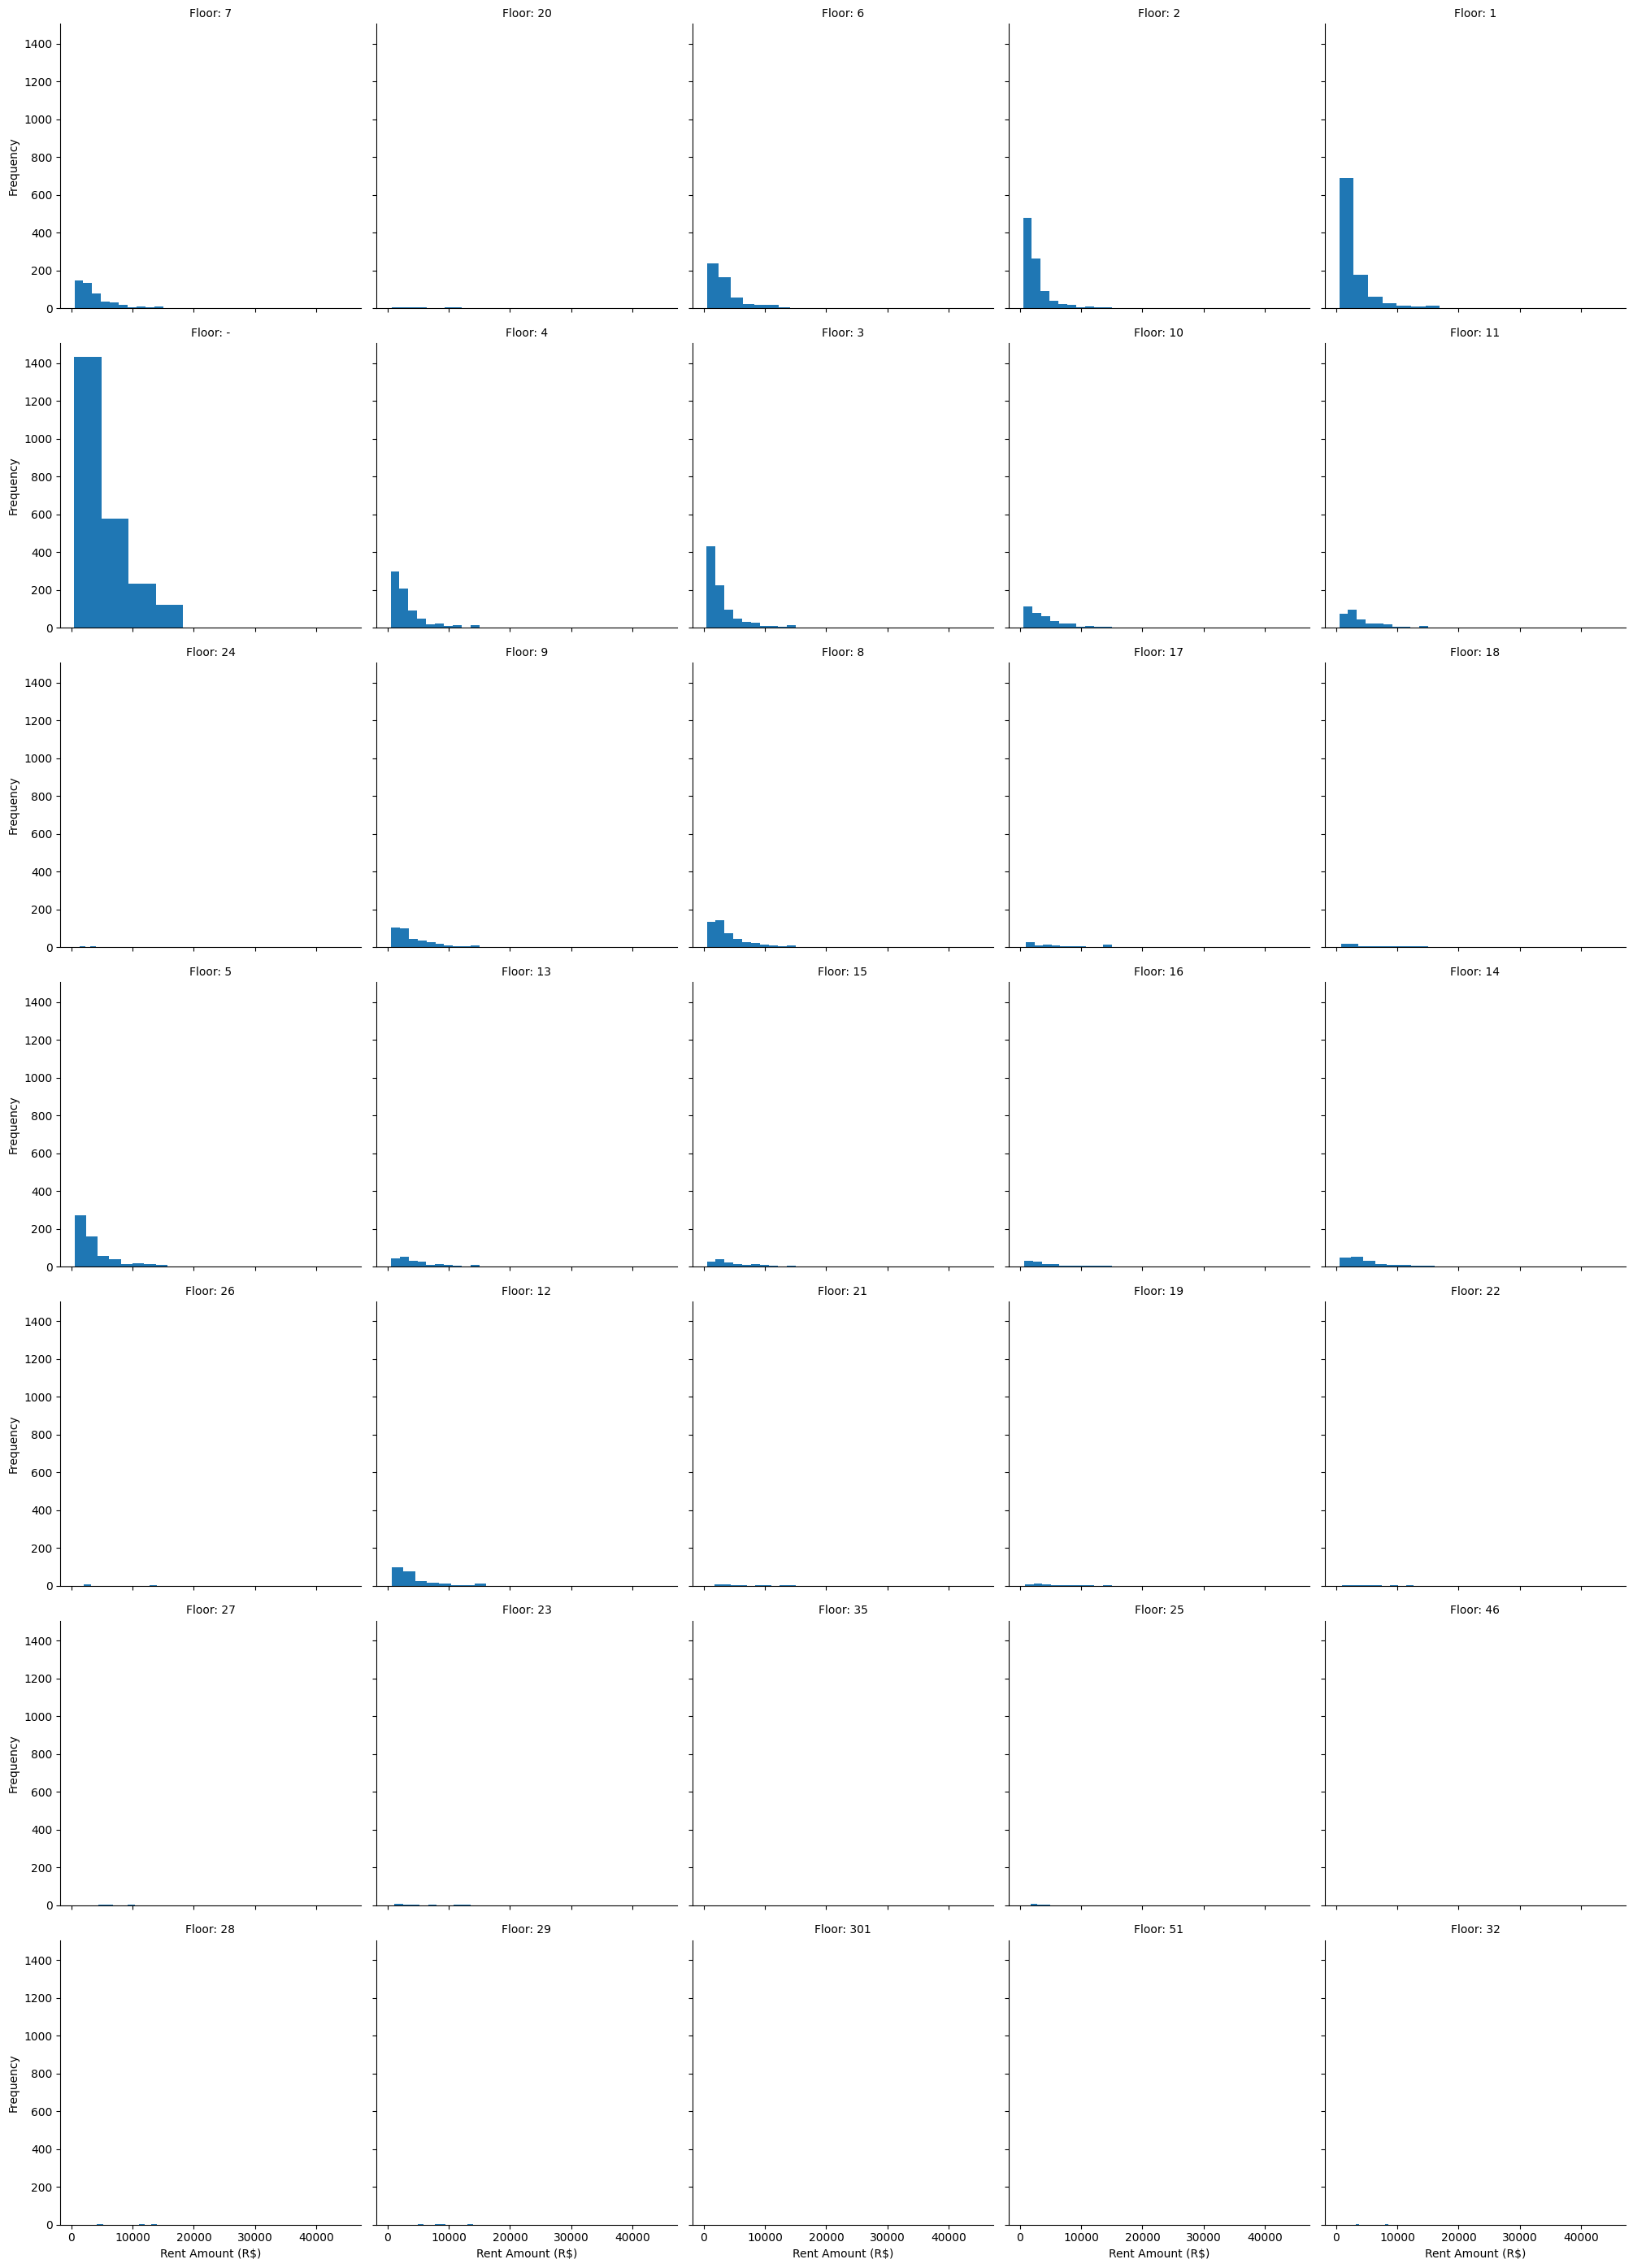

In [15]:
g = sns.FacetGrid(df, col='floor', height=4, col_wrap=5)
g = g.map(plt.hist, 'rent')

g.set_axis_labels('Rent Amount (R$)', 'Frequency')
g.set_titles('Floor: {col_name}')

### animal  
- Há uma tendência de alugueis mais caros aceitarem animais de estimação;
- Aplicar OneHotEncoded

<Axes: xlabel='animal', ylabel='rent'>

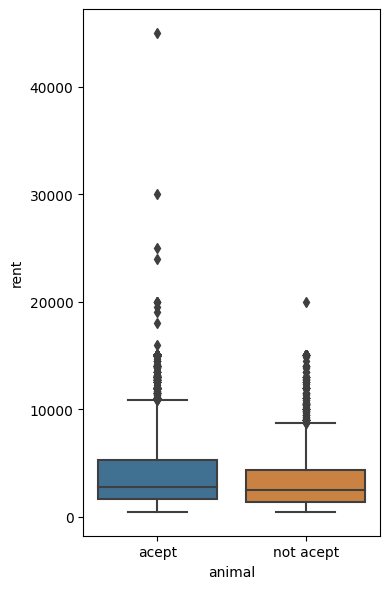

In [61]:
plt.figure(figsize=(4, 6))
sns.boxplot(x=df['animal'], y=df['rent'], palette=['#3274A1', '#E1812C'])

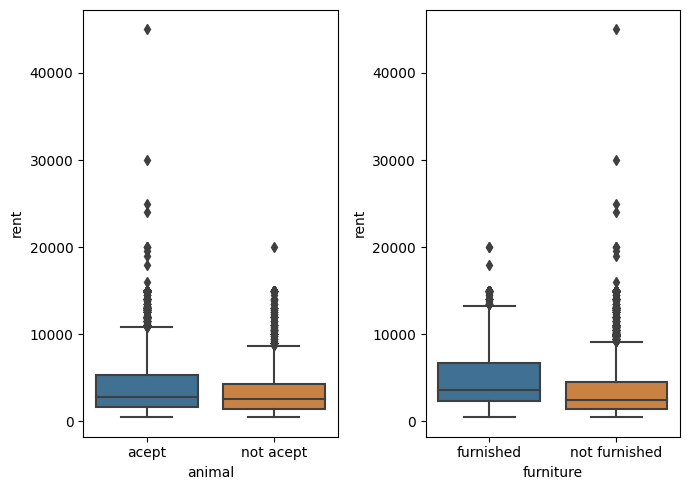

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supondo que 'df' seja o seu DataFrame
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 5))  # Cria uma figura com 1 linha e 2 colunas

# Boxplot para 'animal'
sns.boxplot(x=df['animal'], y=df['rent'], palette=['#3274A1', '#E1812C'], ax=axes[0])

# Boxplot para 'furniture'
sns.boxplot(x=df['furniture'], y=df['rent'], palette=['#3274A1', '#E1812C'], ax=axes[1])

# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Exibe o gráfico
plt.show()


<Axes: xlabel='animal', ylabel='rent'>

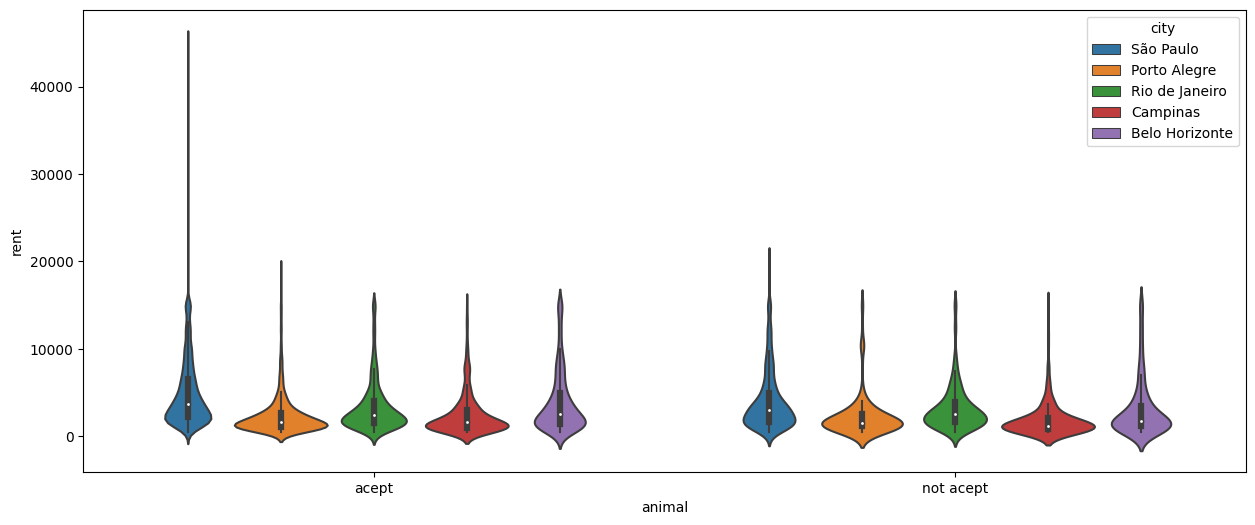

In [17]:
plt.figure(figsize=(15, 6))
sns.violinplot(x ='animal', y ='rent', data = df, hue ='city')

### furniture  
- Há uma tendência de alugueis mais caros serem de imóveis mobiliados;
- Aplicar OneHotEncoded

<Axes: xlabel='furniture', ylabel='rent'>

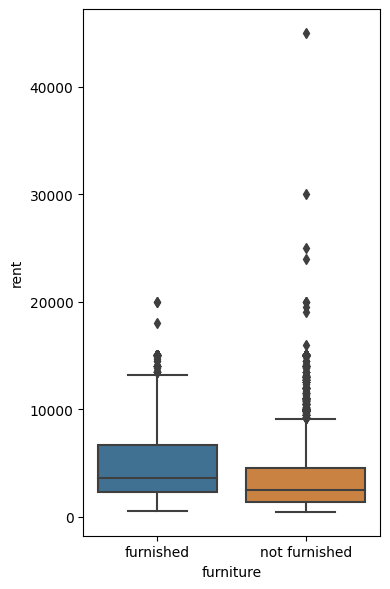

In [58]:
plt.figure(figsize=(4, 6))
sns.boxplot(x=df['furniture'], y=df['rent'], palette=['#3274A1', '#E1812C'])

<Axes: xlabel='furniture', ylabel='rent'>

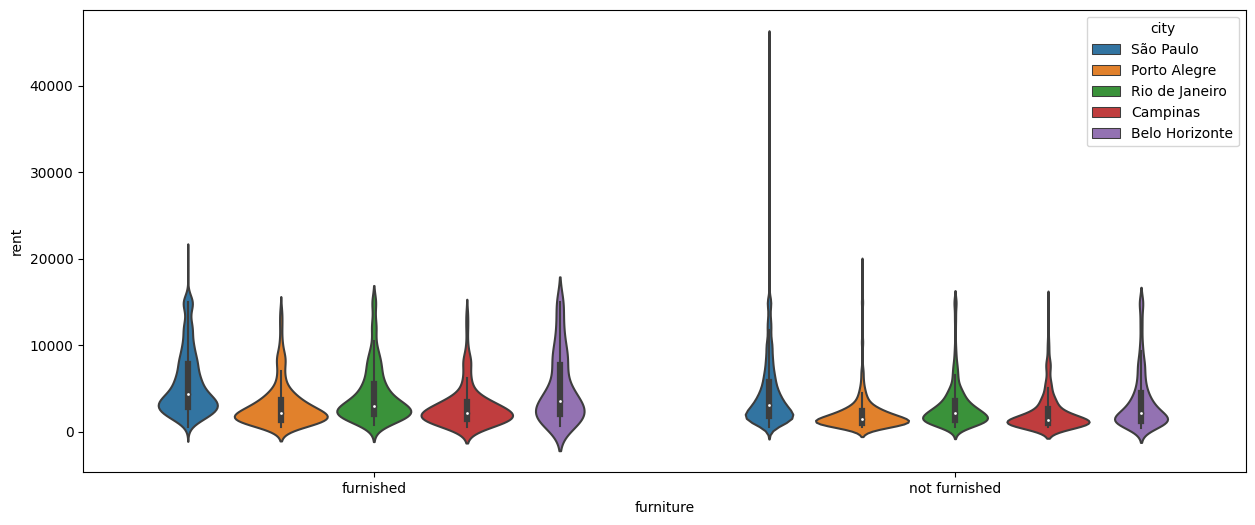

In [19]:
plt.figure(figsize=(15, 6))
sns.violinplot(x ='furniture', y ='rent', data = df, hue ='city')

## Numéricas
 - ['area', 'rooms', 'bathroom', 'parking_spaces', 'hoa', 'rent', 'property_tax', 'fire_insurance']
   - Discretas: ['rooms', 'bathroom', 'parking_spaces']
   - Contínuas: ['area', 'hoa', 'rent', 'property_tax', 'fire_insurance']

Todas as variáveis discretas possuem tendência linear até seus outliers (<5% de registros)

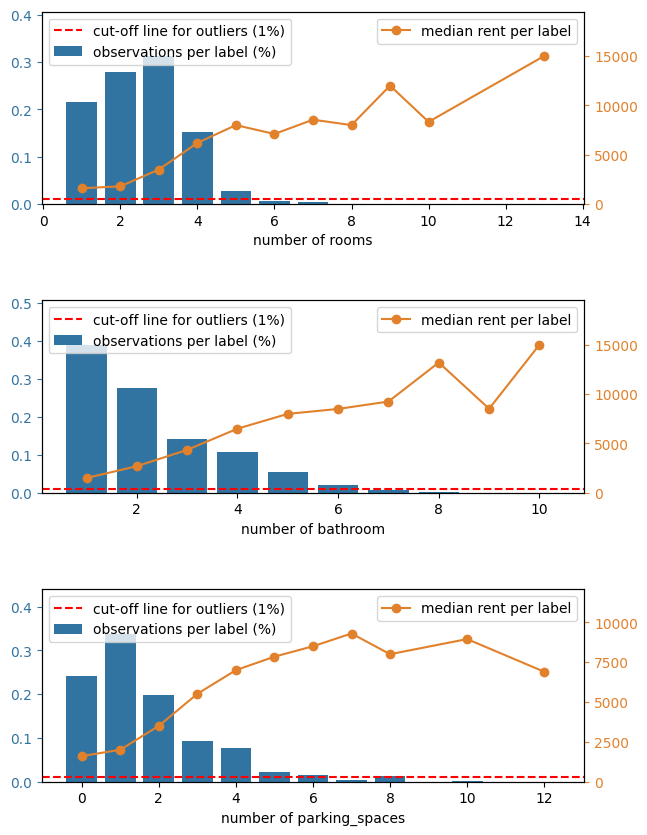

In [20]:

# Estudo sobre as variáveis discretas
new_visualize_discrete(df=df, discrete=discrete, show_red_line=True)

Todas as variáveis conítuas possuem outliers iqr

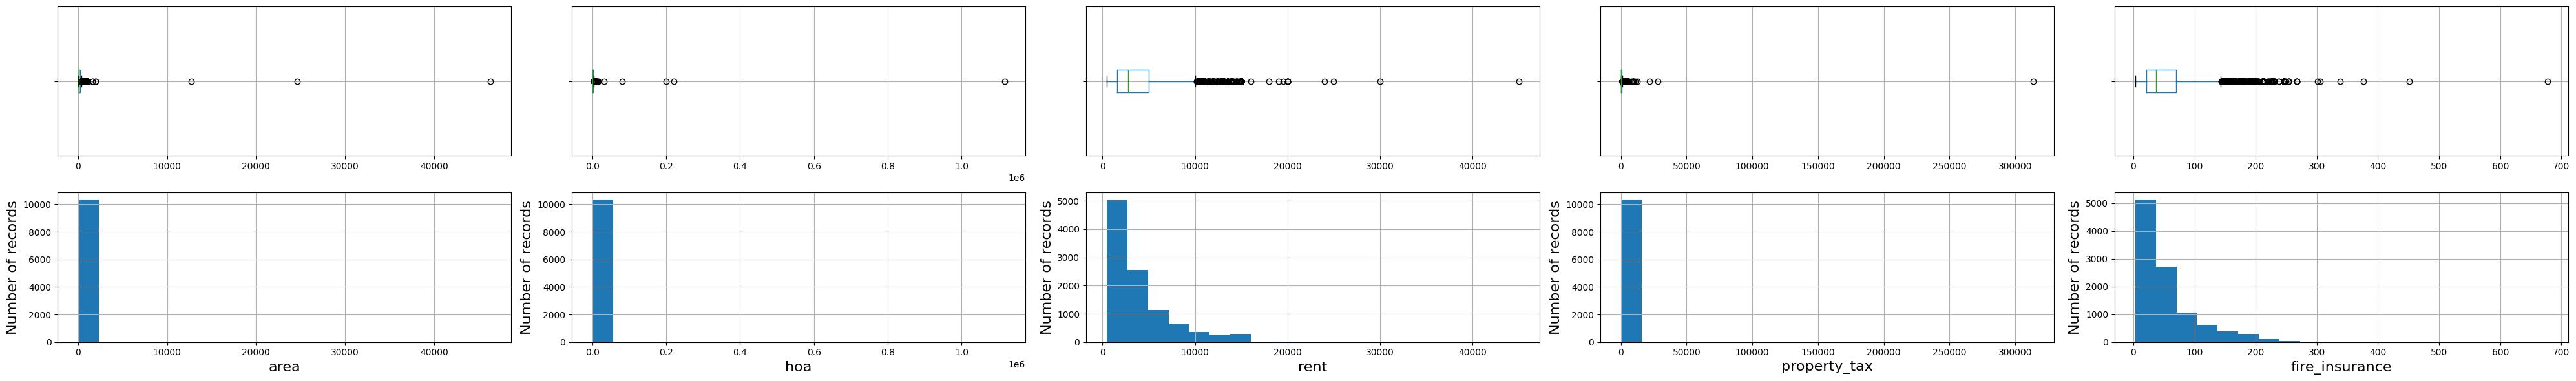

In [21]:
visualize_continuous(df=df, continuous=continuous)

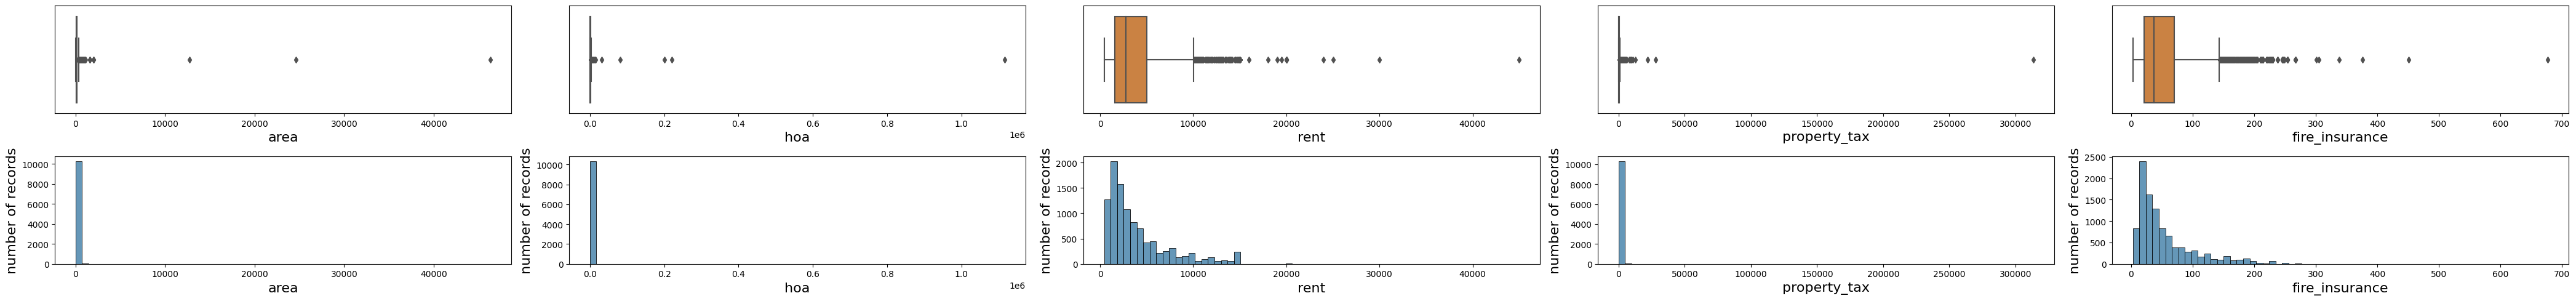

In [22]:
def new_visualize_continuous(df, continuous):
    plt.figure(figsize=(42, 5))
    position = 0
    for var in continuous:
        position += 1
        plt.subplot(2, 5, position)
        sns.boxplot(x=df[var], orient='h', color='#E1812C')
        plt.title('')
        plt.yticks([])
        plt.xlabel(var, fontsize=16)
        # fig = df.boxplot(column=var, vert=False)
        # fig.set_title('')
        # fig.set_yticklabels([])

    for var in continuous:
        position += 1
        plt.subplot(2, 5, position)
        sns.histplot(df[var], bins=64, color='#3274A1')
        plt.ylabel('number of records', fontsize=16)
        plt.xlabel(var, fontsize=16)
        # fig = df[var].hist(bins=20)
        # fig.set_ylabel('Number of records', fontsize=16)
        # fig.set_xlabel(var, fontsize=16)
    
    plt.tight_layout()
    plt.show()

new_visualize_continuous(df=df, continuous=continuous)

In [23]:
numerical, categorical, discrete, continuous = distinguish_variables(df)

print("Categoricas: " + str(categorical))
print("Numericas: " + str(numerical))

print(" - Discretas: " + str(discrete))
print(" - Contínuas: " + str(continuous))

Categoricas: ['city', 'floor', 'animal', 'furniture']
Numericas: ['area', 'rooms', 'bathroom', 'parking_spaces', 'hoa', 'rent', 'property_tax', 'fire_insurance']
 - Discretas: ['rooms', 'bathroom', 'parking_spaces']
 - Contínuas: ['area', 'hoa', 'rent', 'property_tax', 'fire_insurance']


### Tratamento de Outliers

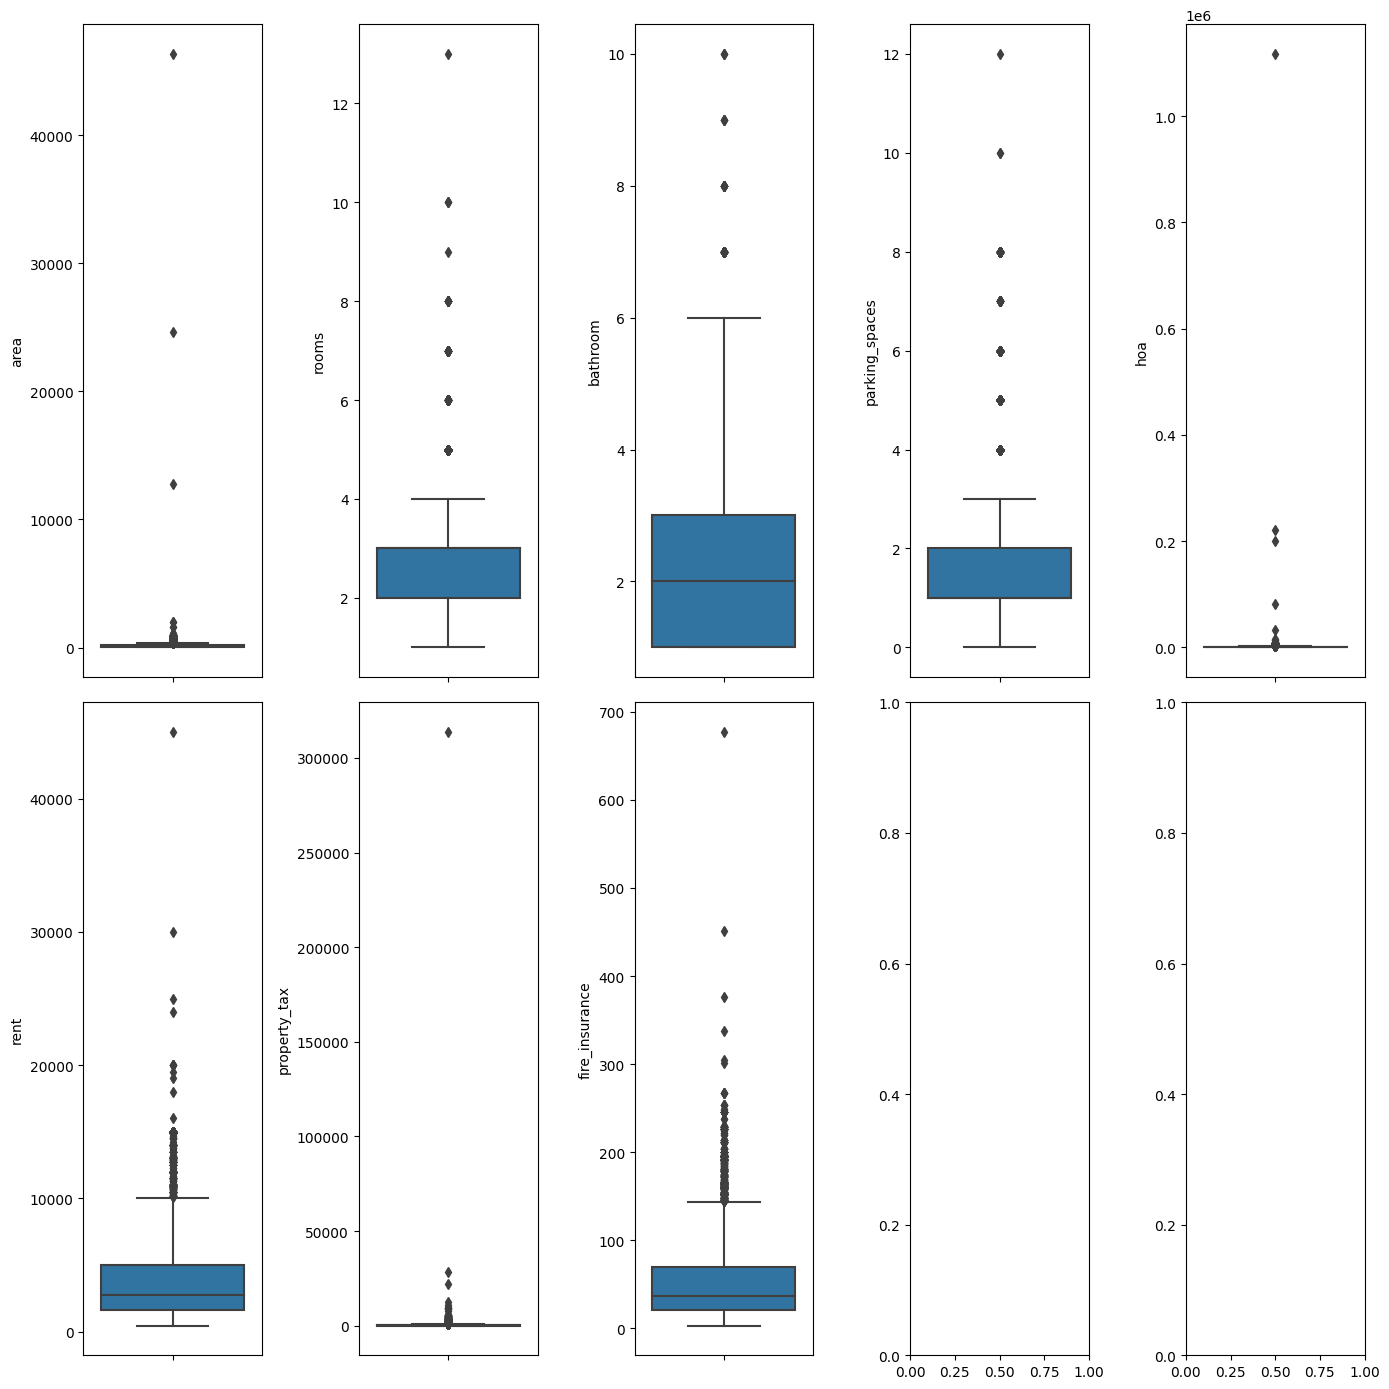

In [24]:
visualize_boxplot(df)

In [25]:
df.describe()

,area,rooms,bathroom,parking_spaces,hoa,rent,property_tax,fire_insurance
count,10334.000000,10334.000000,10334.000000,10334.000000,1.033400e+04,10334.000000,10334.000000,10334.000000
mean,152.439423,2.539965,2.268725,1.644475,1.091244e+03,3966.296013,376.929263,54.264273
std,545.875595,1.168185,1.414650,1.598527,1.144609e+04,3436.190007,3160.602165,48.164380
min,11.000000,1.000000,1.000000,0.000000,0.000000e+00,450.000000,0.000000,3.000000
25%,59.000000,2.000000,1.000000,1.000000,1.800000e+02,1598.250000,41.000000,21.000000
50%,95.000000,3.000000,2.000000,1.000000,5.710000e+02,2750.000000,130.000000,37.000000
75%,190.000000,3.000000,3.000000,2.000000,1.286750e+03,5000.000000,389.750000,70.000000
max,46335.000000,13.000000,10.000000,12.000000,1.117000e+06,45000.000000,313700.000000,677.000000


In [26]:
# Categoricas: ['city', 'animal', 'furniture']
# Numericas: ['area', 'rooms', 'bathroom', 'parking_spaces', 'floor', 'hoa', 'rent', 'property_tax', 'fire_insurance', 'total']
#  - Discretas: ['rooms', 'bathroom', 'parking_spaces']
#  - Contínuas: ['area', 'floor', 'hoa', 'rent', 'property_tax', 'fire_insurance', 'total']

df_clean = df.drop(["floor"], axis=1)

df_clean = trimmer_skewed_iqr(
    variables=continuous,
    data_frame=df_clean,
)

df_clean = trimmer_normal_quantile(
    variables=discrete,
    data_frame=df_clean,
)

df_clean.info()
# https://www.kaggle.com/datasets/rubenssjr/brasilian-houses-to-rent/code?datasetId=554905&sortBy=voteCount

<class 'pandas.core.frame.DataFrame'>
Index: 8490 entries, 0 to 10691
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   city            8490 non-null   object
 1   area            8490 non-null   int64 
 2   rooms           8490 non-null   int64 
 3   bathroom        8490 non-null   int64 
 4   parking_spaces  8490 non-null   int64 
 5   animal          8490 non-null   object
 6   furniture       8490 non-null   object
 7   hoa             8490 non-null   int64 
 8   rent            8490 non-null   int64 
 9   property_tax    8490 non-null   int64 
 10  fire_insurance  8490 non-null   int64 
dtypes: int64(8), object(3)
memory usage: 795.9+ KB


Apos o tratamento dos outliers

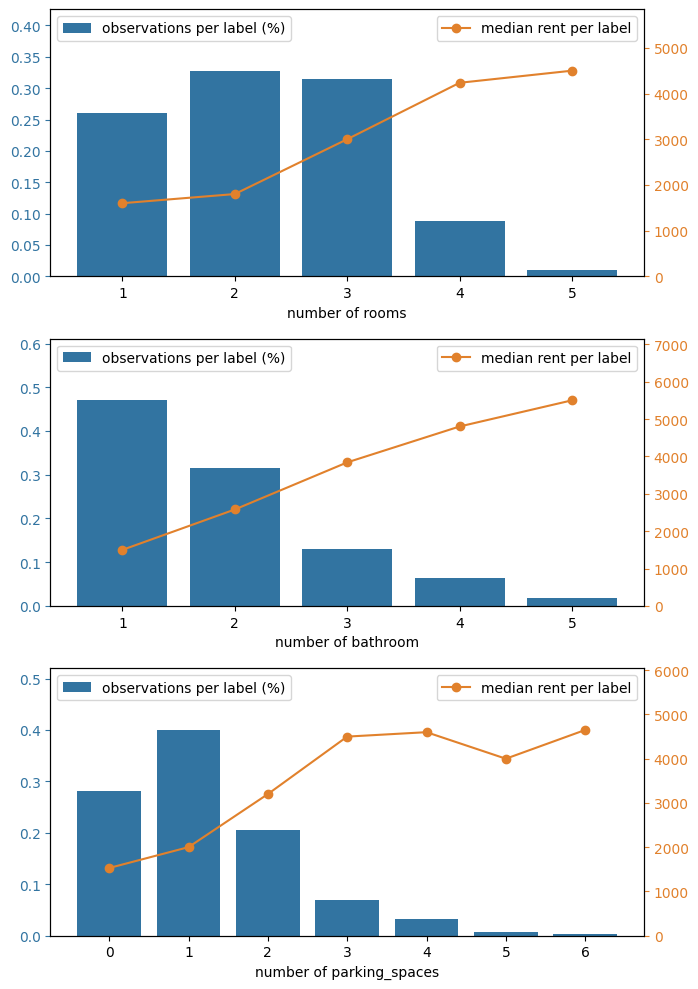

In [27]:
new_visualize_discrete(df=df_clean, discrete=discrete, show_red_line=False)

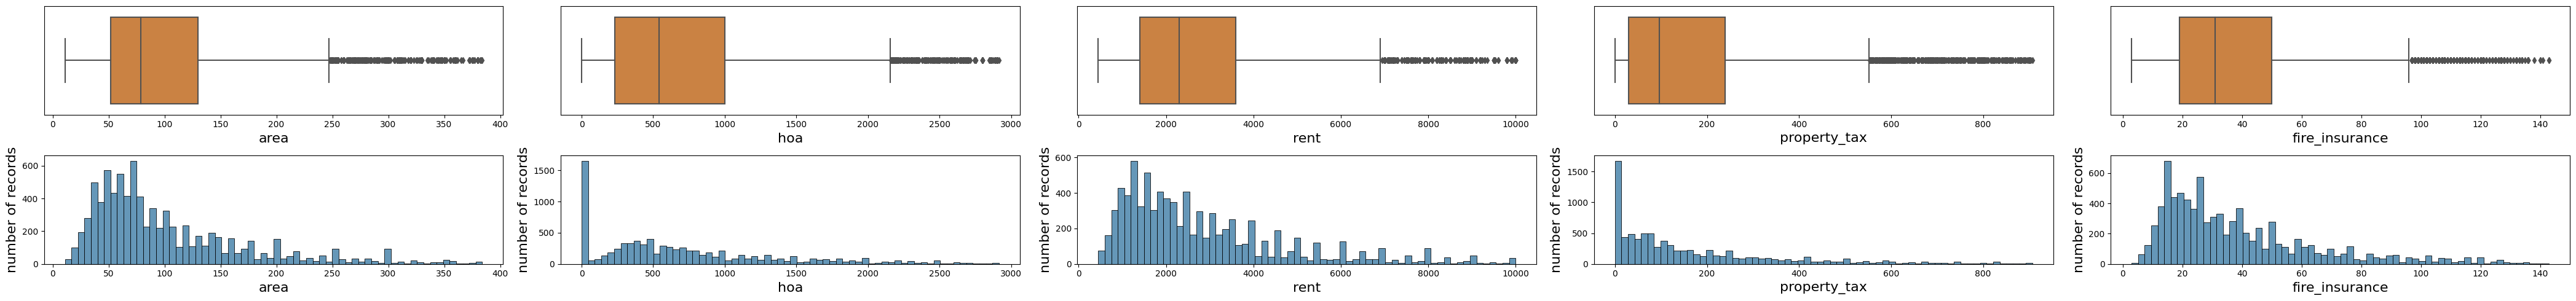

In [28]:
new_visualize_continuous(df=df_clean, continuous=continuous)

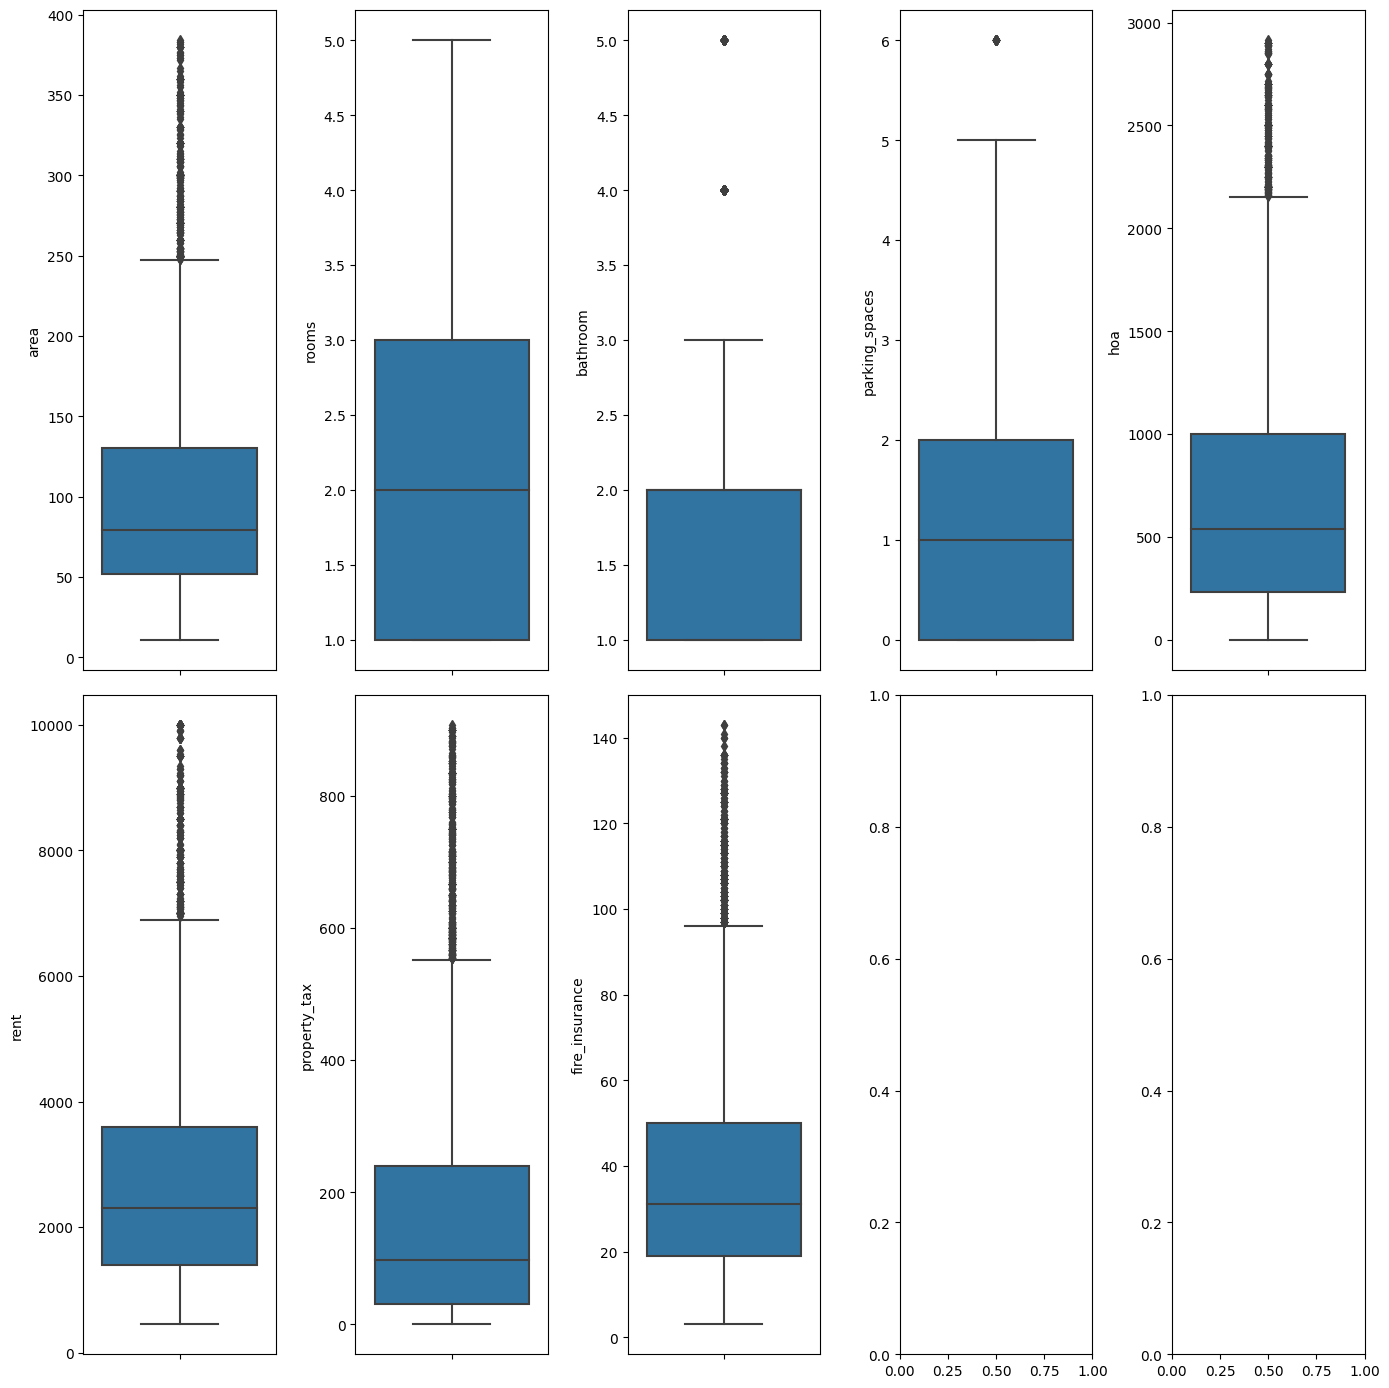

In [29]:
visualize_boxplot(df_clean)

In [30]:
import model as md
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

X = df_clean.loc[:, df_clean.columns != "rent"]
Y = df_clean["rent"]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# Categoricas: ['city', 'animal', 'furniture']
# Numericas: ['area', 'rooms', 'bathroom', 'parking_spaces', 'hoa', 'property_tax', 'fire_insurance']
#  - Discretas: ['rooms', 'bathroom', 'parking_spaces']
#  - Contínuas: ['area', 'hoa', 'property_tax', 'fire_insurance']
# target 'rent'

ct = make_column_transformer(
    (MinMaxScaler(),  # ou StandardScaler(), dependendo de qual performa melhor
     ['area', 'rooms', 'bathroom', 'parking_spaces', 'hoa', 'property_tax', 'fire_insurance']),
    (OneHotEncoder(categories="auto",
                   # to return k-1 (drop=false to return k dummies)
                   drop="first",
                   sparse_output=False,
                   handle_unknown="error"),
     ['city', 'animal', 'furniture']),
    remainder="passthrough"
)

ct.fit(x_train)
x_train = ct.transform(x_train)
x_test = ct.transform(x_test)

m_one = md.Model(x_train, x_test, y_train, y_test)

m_one.model.summary()
m_one.model.evaluate(m_one.x_train, m_one.y_train)

print("-- MAE (train)")
print(m_one.mae_train())
print("-- MAE")
print(m_one.mae())
print("-- MSE (train)")
print(m_one.mse_train())
print("-- MSE")
print(m_one.mse())

ModuleNotFoundError: No module named 'model'